# Volúmenes finitos

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from abc import ABC, abstractmethod
from sympy import *

plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["figure.titlesize"] = 20

In [259]:
class Finite_Volume(ABC):

    def __init__(self, Nx, xL, xR, Nt, tf, f):
        # Esquema a usar
        self.scheme = ""

        # Parametros grilla
        self.Nx = Nx
        self.Nt = Nt
        self.xL = xL
        self.xR = xR
        self.tf = tf

        # Pasos espacial y temporal
        self.dx = (xR - xL) / Nx
        self.dt = self.dx/2#tf / (Nt + 1)

        # Arreglos
        self.x_mid = np.linspace(self.xL, self.xR, self.Nx+1) # puntos medios
        self.x = (self.x_mid[1:] + self.x_mid[:-1]) / 2 # puntos de la grilla

        self.t = np.linspace(0, self.tf, self.Nt)

        # Tiempo actual
        self.n = 0
        
        # Asigna funcion flujo
        self.f = f

        
    # Setea condición inicial
    def set_init_cond(self, U_0):
        
        # Guarda condición inicial
        U0 = U_0(self.x)
        
        # Inicializa solución
        self.U = np.zeros((self.Nt,) + U0.shape)
        
        self.U[0] = U0
        
        # Inicializa vector y función de flujo
        self.F = np.zeros(self.Nx+1)
        self.f = f
    
    # Obtiene derivada de f
    def get_f_prime(self):
        u = Symbol('u')
        y = self.f(u)
        f_prime = y.diff(u)
        self.f_prime = lambdify(u, f_prime)
    
    # Condición CFL
    def CFL_condition(self):
        self.get_f_prime()
        CFL = np.max(np.fabs(self.f_prime(self.U[self.n]))) * (self.dt/self.dx)

        if CFL > 1/2:
            print("Cuidado: No se cumple condición CFL")

    # Flujo esquema
    @abstractmethod
    def scheme_flux(self, u_left, u_right):
        pass
    
    # Flujo en bordes
    def border_flux(self):
        
        # Flujo en el borde izquierdo
        u_left = self.U[self.n, 0]
        u_right = self.U[self.n, 0]
        self.F[0] = self.scheme_flux(u_left, u_right)

        # Flujo en el borde derecho
        u_left = self.U[self.n, -1]
        u_right = self.U[self.n, -1]
        self.F[-1] = self.scheme_flux(u_left, u_right)

    
    # Calcula flujo
    def calculate_flux(self):
        for i in range(1, self.Nx):
            u_left = self.U[self.n, i-1]
            u_right = self.U[self.n, i]
            self.F[i] = self.scheme_flux(u_left, u_right)

        self.border_flux()

    # Actualiza solución
    def update(self):
        self.calculate_flux()

        # Actualiza solucion
        for i in range(self.Nx):
            self.U[self.n+1, i] = self.U[self.n, i] - (self.dt / self.dx) * (self.F[i+1] - self.F[i])
        self.n += 1
    
    # Obtiene animación
    def get_animation(self, title, path):
        fig = plt.figure()
        ax = plt.axes()
        plt.xlabel(r'$x$')
        plt.ylabel(r'$u(t, x)$')
        ax.set_title(title + " t=" + str(format(self.t[0], '.2f')) + " " + self.scheme)

        # prepare for animated lines
        line, = ax.plot(self.x, self.U[0], '-', color='r', linewidth=2, label="Simulación")

        def animate(n):
            line.set_ydata(self.U[n])

            ax.set_title(title + " t=" + str(format(self.t[n], '.2f')) + " " + self.scheme)
            return line,

        ani = animation.FuncAnimation(fig, animate, np.arange(0, self.Nt, 5),
                                    interval=70, blit=True)

        ani.save(path)
    
    # Obtiene animación con solución exacta
    def get_animation_exact(self, title, path, real_solution):
        fig = plt.figure()
        ax = plt.axes()
        plt.xlabel(r'$x$')
        plt.ylabel(r'$u(t, x)$')
        plt.title(title + " t=" + str(format(self.t[0], '.2f')) + " " + self.scheme)

        # prepare for animated lines
        exact_line, = ax.plot(self.x, real_solution(self.x, self.t[0]), linestyle='-', linewidth=2, 
                              label="Solución exacta", zorder=0)
        
        line, = ax.plot(self.x, self.U[0], 'o-', linewidth=2, label="Simulación", zorder=1)
        
        plt.legend()

        def animate(n):
            line.set_ydata(self.U[n])
            exact_line.set_ydata(real_solution(self.x, self.t[n]))

            plt.title(title + " t=" + str(format(self.t[n], '.2f')) + " " + self.scheme)
            return [line, exact_line] 

        ani = animation.FuncAnimation(fig, animate, np.arange(0, self.Nt, 5),
                                    interval=70, blit=True)

        ani.save(path)

## Esquema de Godunov

In [260]:
# Godunov
class Godunov_solver(Finite_Volume):

    def __init__(self, Nx, xL, xR, Nt, tf, f, flux):
        super().__init__(Nx, xL, xR, Nt, tf, f)
        self.flux = flux

        # Esquema
        self.scheme = "Godunov"

    # Flujo esquema
    def scheme_flux(self, u_left, u_right):
        return self.flux(u_left, u_right)

In [261]:
# Godunov con condiciones de borde periodicas
class Godunov_periodic_solver(Godunov_solver):

    def __init__(self, Nx, xL, xR, Nt, tf, f, flux):
        super().__init__(Nx, xL, xR, Nt, tf, f, flux)

    # Flujo en bordes
    def border_flux(self):
        # Flujo en el borde izquierdo
        u_left = self.U[self.n, -1]
        u_right = self.U[self.n, 0]
        self.F[0] = self.scheme_flux(u_left, u_right)

        # Flujo en el borde derecho
        self.F[-1] = self.scheme_flux(u_left, u_right)
    
    # Actualiza solución
    def update(self):
        self.calculate_flux()

        # Actualiza solucion
        for i in range(self.Nx):
            self.U[self.n+1, i] = self.U[self.n, i] - (self.dt / self.dx) * (self.F[i+1] - self.F[i])

        self.n += 1

In [262]:
# Godunov cuando f posee unico mínimo global
class Simplified_Godunov_solver(Finite_Volume):

    def __init__(self, Nx, xL, xR, Nt, tf, f, w):
        super().__init__(Nx, xL, xR, Nt, tf, f)

        # Punto mínimo
        self.w = w

        # Esquema
        self.scheme = "Godunov"

    # Flujo esquema
    def scheme_flux(self, u_left, u_right):
        u_l_positive = np.max([u_left, self.w])
        u_r_negative = np.min([u_right, self.w])

        return np.max([self.f(u_l_positive), self.f(u_r_negative)])

In [166]:
# Parametros grillas
Nx = 80
xL = -1
xR = 1
Nt = 400
tf = 2.5

# Flujo
def f(u):
    return u**2/2

# Condiciones iniciales
def U_0_1(x):
    return (x<0).astype(float)

# Solución real 1
# TODO: Modificar para que funcione con arreglos en x
def u_1(x, t):
    return U_0_1(x-t/2)

def U_0_2(x):
    x_copy = x.copy()
    x_copy[x_copy<0] = -1
    x_copy[x_copy>=0] = 1
    return x_copy

def u_2(x_, t):
    sol = []
    for x in x_:
        if x < -t:
            sol += [-1]

        elif -t <= x < t:
            sol+= [x/t]

        else:
            sol+=[1]
    return sol


MovieWriter ffmpeg unavailable; using Pillow instead.


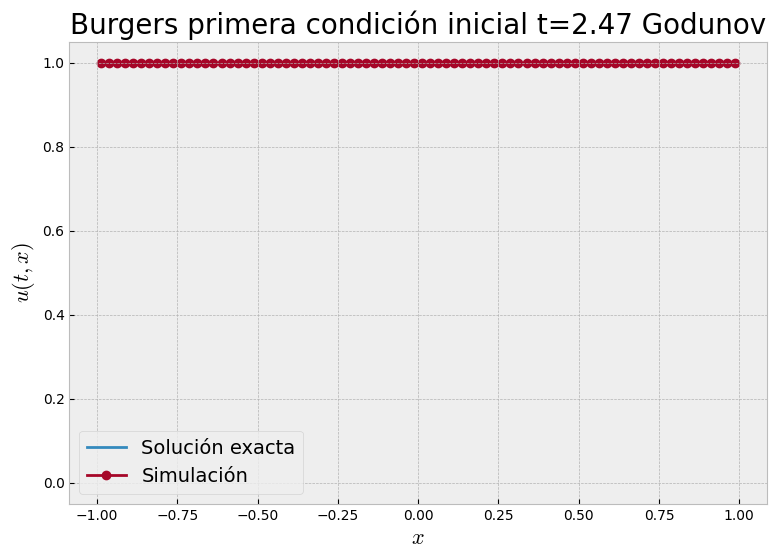

In [167]:
# Solución con primera condición inicial
burgers_1 = Simplified_Godunov_solver(Nx, xL, xR, Nt, tf, f, 0)
burgers_1.set_init_cond(U_0_1)

for n in range(0,Nt-1):
    burgers_1.CFL_condition()
    burgers_1.update()

burgers_1.get_animation_exact("Burgers primera condición inicial", "Charts/First_order/Godunov/burgers_1.gif", u_1)

MovieWriter ffmpeg unavailable; using Pillow instead.


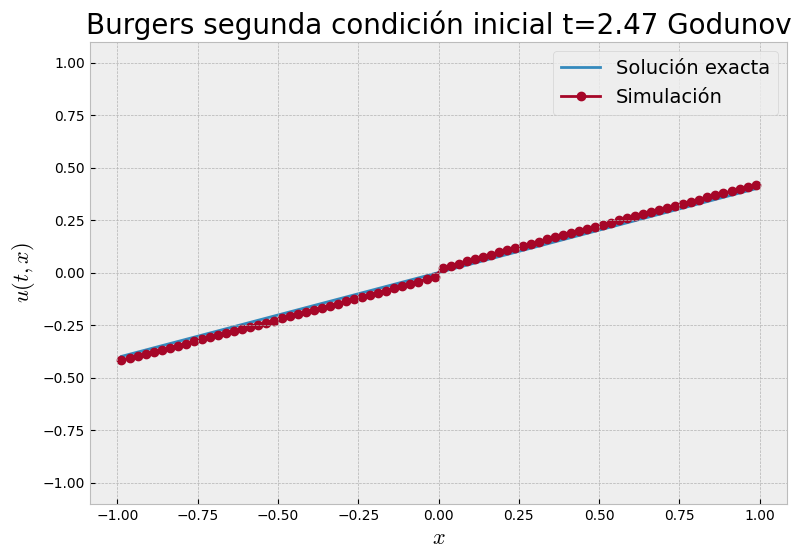

In [168]:
# Solucion con segunda condicion inicial
burgers_2 = Simplified_Godunov_solver(Nx, xL, xR, Nt, tf, f, 0)
burgers_2.set_init_cond(U_0_2)

for n in range(0,Nt-1):
    burgers_2.CFL_condition()
    burgers_2.update()

burgers_2.get_animation_exact("Burgers segunda condición inicial", "Charts/First_order/Godunov/burgers_2.gif", u_2)

In [263]:
# Godunov con condiciones de borde periodicas
class Simplified_Godunov_periodic_solver(Simplified_Godunov_solver):

    def __init__(self, Nx, xL, xR, Nt, tf, f, w):
        super().__init__(Nx, xL, xR, Nt, tf, f, w)

    # Flujo en bordes
    def border_flux(self):
        # Flujo en el borde izquierdo
        u_left = self.U[self.n, -1]
        u_right = self.U[self.n, 0]
        self.F[0] = self.scheme_flux(u_left, u_right)

        # Flujo en el borde derecho
        self.F[-1] = self.scheme_flux(u_left, u_right)
    
    # Actualiza solución
    def update(self):
        self.calculate_flux()

        # Actualiza solucion
        for i in range(self.Nx):
            self.U[self.n+1, i] = self.U[self.n, i] - (self.dt / self.dx) * (self.F[i+1] - self.F[i])

        self.n += 1

MovieWriter ffmpeg unavailable; using Pillow instead.


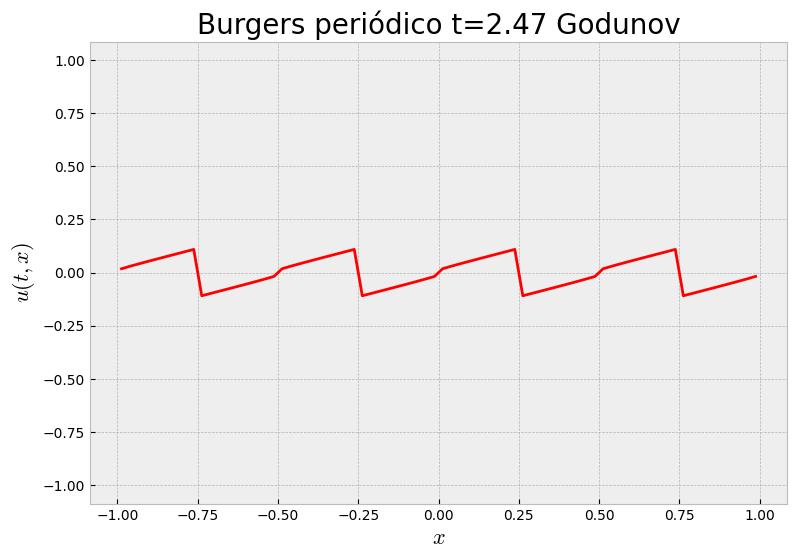

In [170]:
def U_0_3(x):
    return np.sin(4*np.pi*x)

burgers_per = Simplified_Godunov_periodic_solver(Nx, xL, xR, Nt, tf, f, 0)
burgers_per.set_init_cond(U_0_3)

for n in range(0,Nt-1):
    burgers_per.CFL_condition()
    burgers_per.update()

burgers_per.get_animation("Burgers periódico", "Charts/First_order/Godunov/burgers_per.gif")

## Solvers linealizados

In [264]:
# Esquema linealizado
class Linearized_solver(Finite_Volume):

    def __init__(self, Nx, xL, xR, Nt, tf, f):
        super().__init__(Nx, xL, xR, Nt, tf, f)
        self.get_f_prime()

        # Esquema
        self.scheme = "Lineal"

    # Flujo esquema
    def scheme_flux(self, u_left, u_right):
        A = self.f_prime(u_left)
        if u_left != u_right:
            A = (self.f(u_right) - self.f(u_left))/(u_right - u_left)
        
        if A>= 0:
            return self.f(u_left)

        else:
            return self.f(u_right)


MovieWriter ffmpeg unavailable; using Pillow instead.


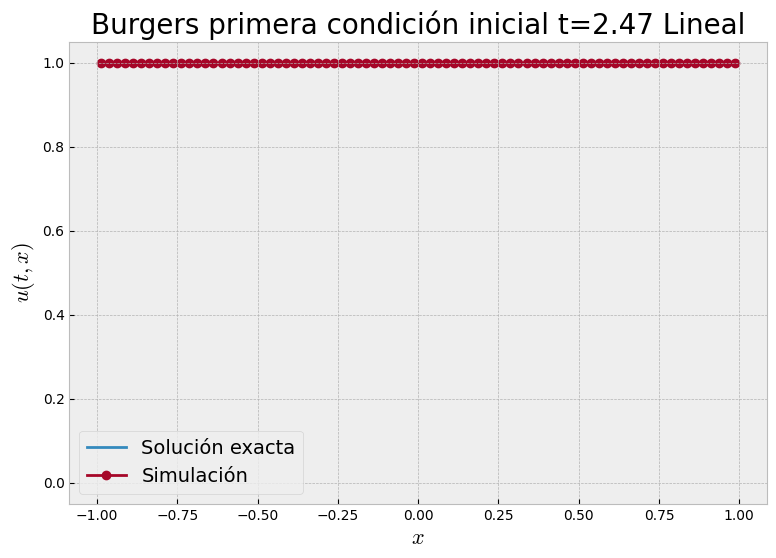

In [172]:
# Solución con primera condición inicial
burgers_1_lin = Linearized_solver(Nx, xL, xR, Nt, tf, f)
burgers_1_lin.set_init_cond(U_0_1)

for n in range(0,Nt-1):
    burgers_1_lin.CFL_condition()
    burgers_1_lin.update()

burgers_1_lin.get_animation_exact("Burgers primera condición inicial", 
                            "Charts/First_order/Lineal/burgers_1_lin.gif", u_1)

MovieWriter ffmpeg unavailable; using Pillow instead.


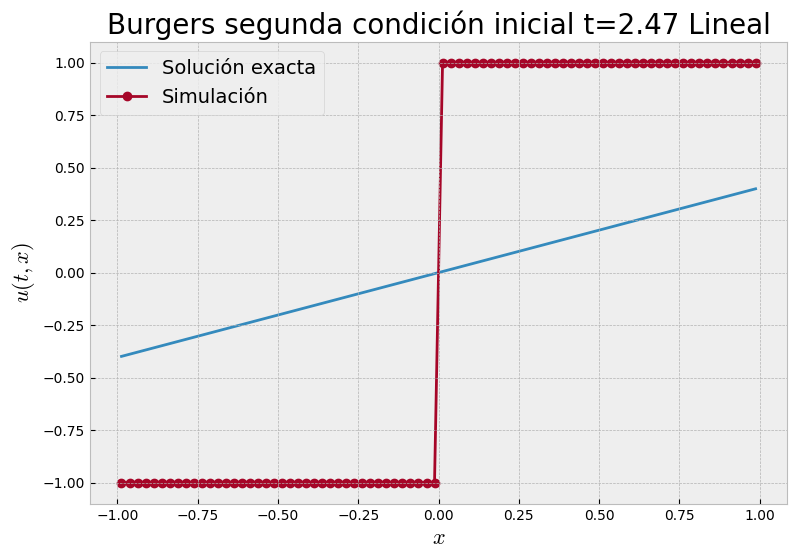

In [173]:
# Solución con segunda condición inicial
burgers_2_lin = Linearized_solver(Nx, xL, xR, Nt, tf, f)
burgers_2_lin.set_init_cond(U_0_2)

for n in range(0,Nt-1):
    burgers_2_lin.CFL_condition()
    burgers_2_lin.update()

burgers_2_lin.get_animation_exact("Burgers segunda condición inicial", 
                            "Charts/First_order/Lineal/burgers_2_lin.gif", u_2)

## Esquemas centrales

In [265]:
class Central_solvers(Finite_Volume, ABC):
    def __init__(self, Nx, xL, xR, Nt, tf, f):
        super().__init__(Nx, xL, xR, Nt, tf, f)
    
    # Obtiene velocidad de onda
    @abstractmethod
    def get_s(self, u_left, u_right):
        pass

    # Flujo esquema
    def scheme_flux(self, u_left, u_right):
        s = self.get_s(u_left, u_right)
        f_star = (self.f(u_left) + self.f(u_right))/2 - (s/2 * (u_right - u_left))
        return f_star

### Lax–Friedrichs

In [266]:
class L_F_solver(Central_solvers):
    def __init__(self, Nx, xL, xR, Nt, tf, f):
        super().__init__(Nx, xL, xR, Nt, tf, f)
        # Esquema
        self.scheme = "L-F"
    
    # Obtiene velocidad de onda
    def get_s(self, u_left, u_right):
        return self.dx/self.dt

MovieWriter ffmpeg unavailable; using Pillow instead.


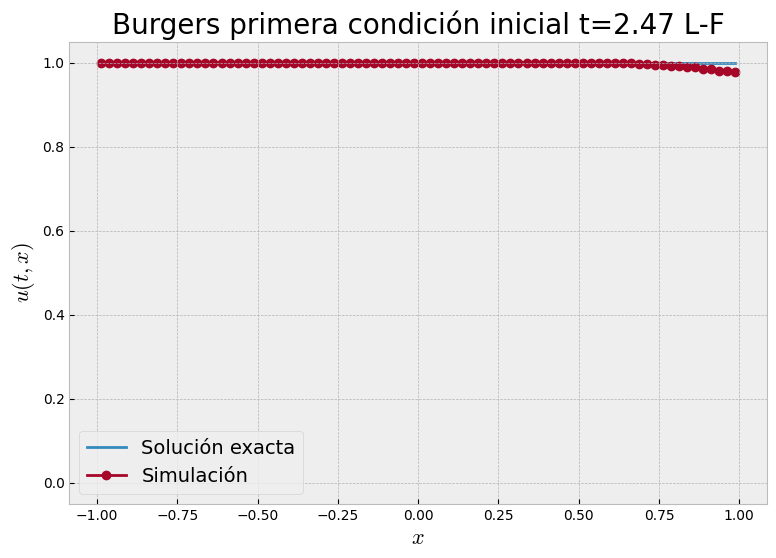

In [176]:
# Solución con primera condición inicial
burgers_1_L_F = L_F_solver(Nx, xL, xR, Nt, tf, f)
burgers_1_L_F.set_init_cond(U_0_1)

for n in range(0,Nt-1):
    burgers_1_L_F.CFL_condition()
    burgers_1_L_F.update()

burgers_1_L_F.get_animation_exact("Burgers primera condición inicial", 
                            "Charts/First_order/L_F/burgers_1_L_F.gif", u_1)

MovieWriter ffmpeg unavailable; using Pillow instead.


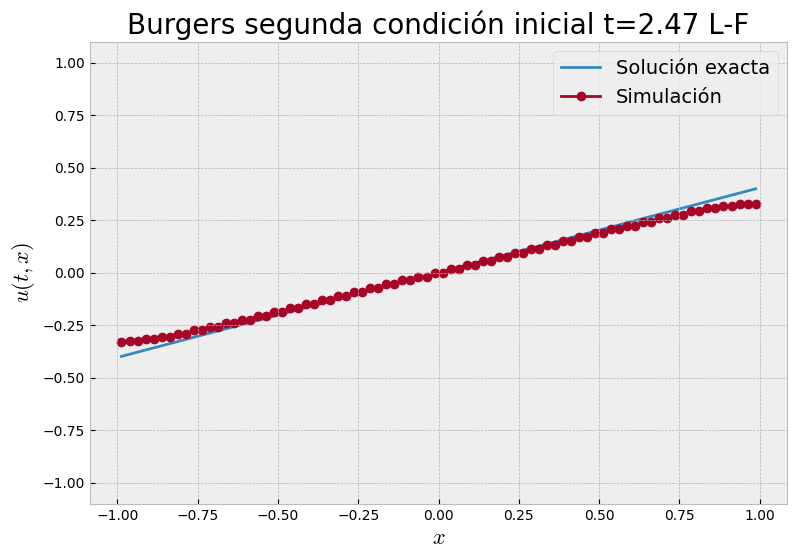

In [177]:
# Solución con segunda condición inicial
burgers_2_L_F = L_F_solver(Nx, xL, xR, Nt, tf, f)
burgers_2_L_F.set_init_cond(U_0_2)

for n in range(0,Nt-1):
    burgers_2_L_F.CFL_condition()
    burgers_2_L_F.update()

burgers_2_L_F.get_animation_exact("Burgers segunda condición inicial", 
                            "Charts/First_order/L_F/burgers_2_L_F.gif", u_2)

### Rusanov

In [267]:
class Rusanov_solver(Central_solvers):
    def __init__(self, Nx, xL, xR, Nt, tf, f):
        super().__init__(Nx, xL, xR, Nt, tf, f)
        self.get_f_prime()
        # Esquema
        self.scheme = "Rusanov"
    
    # Obtiene velocidad de onda
    def get_s(self, u_left, u_right):
        output = np.max([np.fabs(self.f_prime(u_left)), np.fabs(self.f_prime(u_right))])
        return output

MovieWriter ffmpeg unavailable; using Pillow instead.


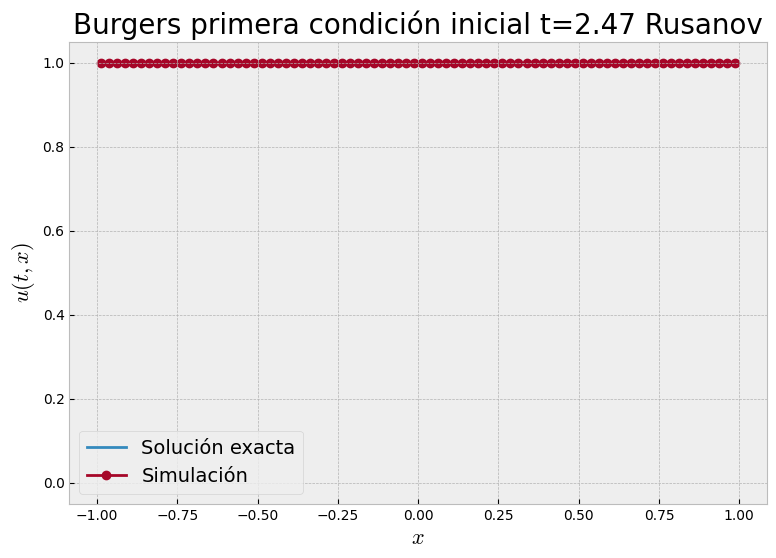

In [179]:
# Solución con primera condición inicial
burgers_1_rus = Rusanov_solver(Nx, xL, xR, Nt, tf, f)
burgers_1_rus.set_init_cond(U_0_1)

for n in range(0,Nt-1):
    burgers_1_rus.CFL_condition()
    burgers_1_rus.update()

burgers_1_rus.get_animation_exact("Burgers primera condición inicial", 
                            "Charts/First_order/Rusanov/burgers_1_rus.gif", u_1)

MovieWriter ffmpeg unavailable; using Pillow instead.


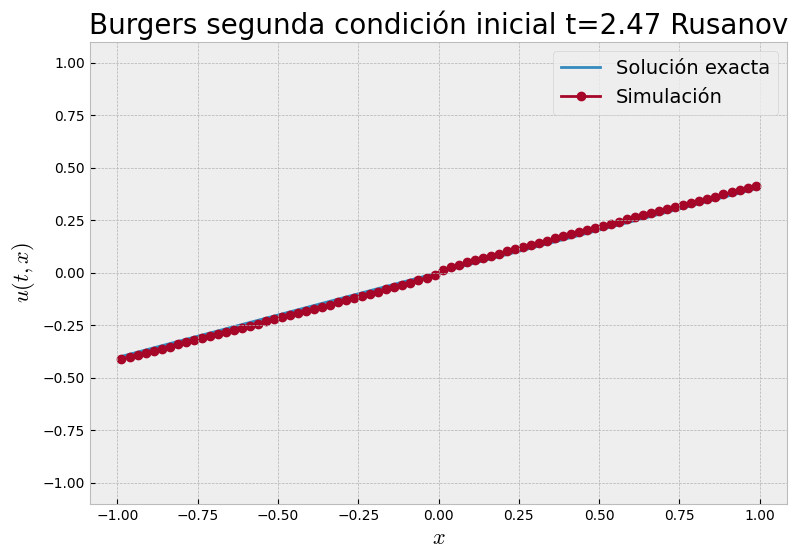

In [180]:
# Solución con segunda condición inicial
burgers_2_rus = Rusanov_solver(Nx, xL, xR, Nt, tf, f)
burgers_2_rus.set_init_cond(U_0_2)

for n in range(0,Nt-1):
    burgers_2_rus.CFL_condition()
    burgers_2_rus.update()

burgers_2_rus.get_animation_exact("Burgers segunda condición inicial", 
                            "Charts/First_order//Rusanov/burgers_2_rus.gif", u_2)

## Esquema Engquist–Osher (simplificado)

In [268]:
# E-O cuando f posee unico mínimo global
class Simplified_E_O_solver(Finite_Volume):

    def __init__(self, Nx, xL, xR, Nt, tf, f, w):
        super().__init__(Nx, xL, xR, Nt, tf, f)

        # Punto mínimo
        self.w = w

        # Esquema
        self.scheme = "E-O"

    # Flujo esquema
    def scheme_flux(self, u_left, u_right):
        u_l_positive = np.max([u_left, self.w])
        u_r_negative = np.min([u_right, self.w])

        return self.f(u_l_positive) + self.f(u_r_negative) - self.f(self.w)

MovieWriter ffmpeg unavailable; using Pillow instead.


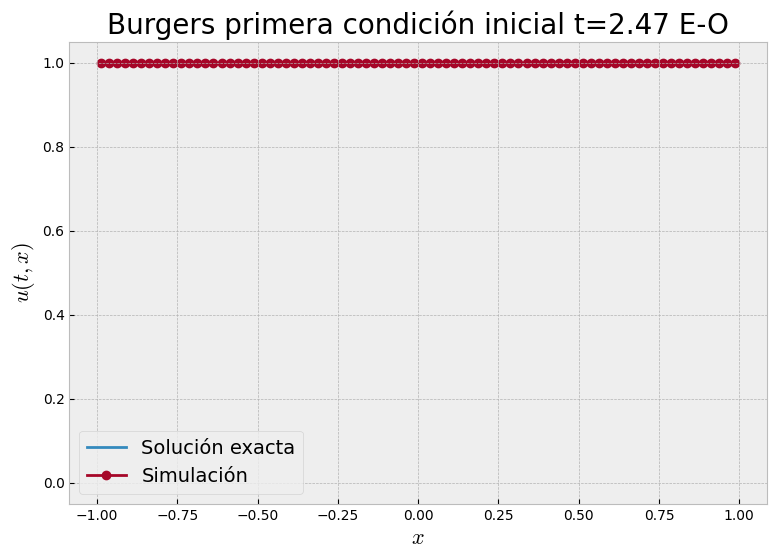

In [182]:
# Solución con primera condición inicial
burgers_1_E_O = Simplified_E_O_solver(Nx, xL, xR, Nt, tf, f, 0)
burgers_1_E_O.set_init_cond(U_0_1)

for n in range(0,Nt-1):
    burgers_1_E_O.CFL_condition()
    burgers_1_E_O.update()

burgers_1_E_O.get_animation_exact("Burgers primera condición inicial", 
                            "Charts/First_order/E_O/burgers_1_E_O.gif", u_1)

MovieWriter ffmpeg unavailable; using Pillow instead.


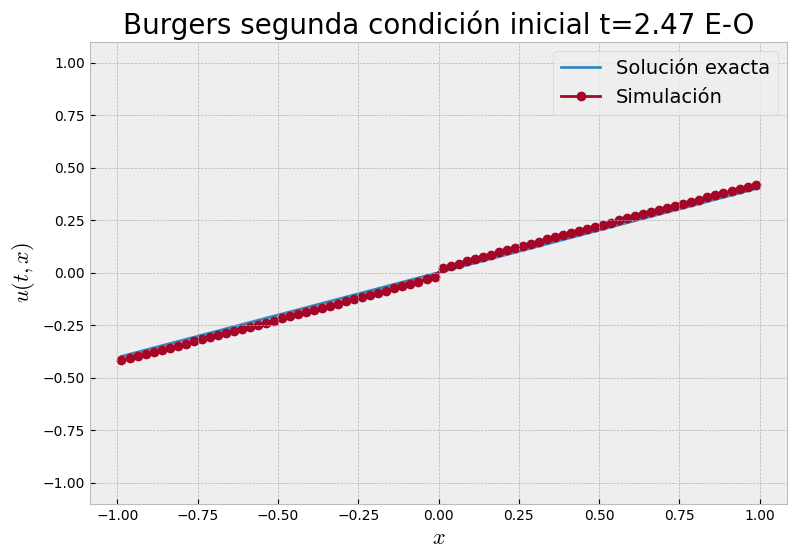

In [183]:
# Solución con segunda condición inicial
burgers_2_E_O = Simplified_E_O_solver(Nx, xL, xR, Nt, tf, f, 0)
burgers_2_E_O.set_init_cond(U_0_2)

for n in range(0,Nt-1):
    burgers_2_E_O.CFL_condition()
    burgers_2_E_O.update()

burgers_2_E_O.get_animation_exact("Burgers segunda condición inicial", 
                            "Charts/First_order/E_O/burgers_2_E_O.gif", u_2)

## Comparativa todos los esquemas

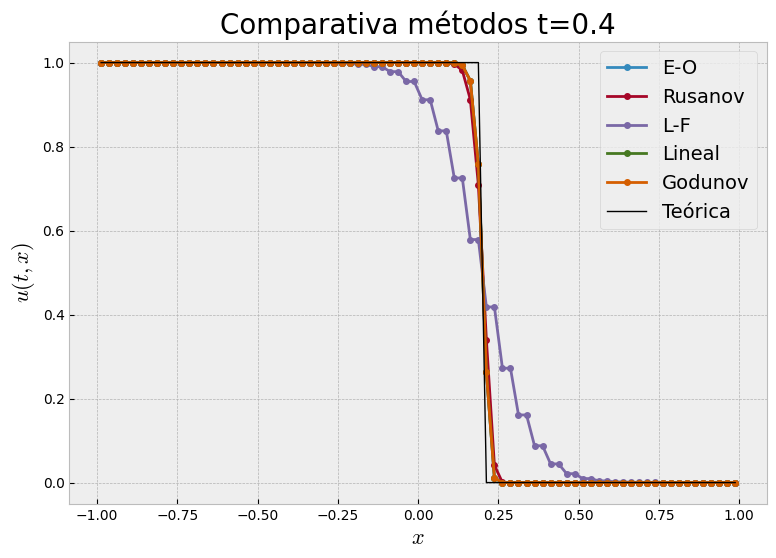

In [226]:
n_t = 64
plt.plot(burgers_1_E_O.x, burgers_1_E_O.U[n_t], "o-", label="E-O", markersize=4)
plt.plot(burgers_1_E_O.x, burgers_1_rus.U[n_t], "o-", label="Rusanov", markersize=4)
plt.plot(burgers_1_E_O.x, burgers_1_L_F.U[n_t], "o-", label="L-F", markersize=4)
plt.plot(burgers_1_E_O.x, burgers_1_lin.U[n_t], "o-", label="Lineal", markersize=4)
plt.plot(burgers_1_E_O.x, burgers_1.U[n_t], "o-", label="Godunov", markersize=4)
plt.plot(burgers_1_E_O.x, u_1(burgers_1_E_O.x, n_t*burgers_1_E_O.dt), label="Teórica", color="black", lw=1)
plt.title("Comparativa métodos t={}".format(round(n_t*burgers_1_E_O.dt, 2)))
plt.xlabel(r"$x$")
plt.ylabel(r"$u(t,x)$")
plt.legend()
plt.savefig("Charts/Comparativa/comp_1")
plt.show()

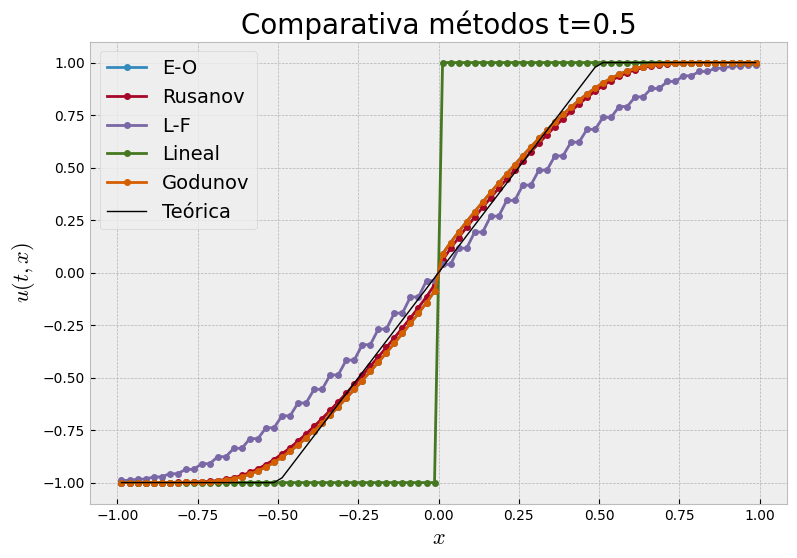

In [417]:
n_t = 80
plt.plot(burgers_2_E_O.x, burgers_2_E_O.U[n_t], "o-", label="E-O", markersize=4)
plt.plot(burgers_2_E_O.x, burgers_2_rus.U[n_t], "o-", label="Rusanov", markersize=4)
plt.plot(burgers_2_E_O.x, burgers_2_L_F.U[n_t], "o-", label="L-F", markersize=4)
plt.plot(burgers_2_E_O.x, burgers_2_lin.U[n_t], "o-", label="Lineal", markersize=4)
plt.plot(burgers_2_E_O.x, burgers_2.U[n_t], "o-", label="Godunov", markersize=4)
plt.plot(burgers_2_E_O.x, u_2(burgers_2_E_O.x, n_t*burgers_2_E_O.dt), label="Teórica", color="black", lw=1)
plt.legend()
plt.title("Comparativa métodos t={}".format(round(n_t*burgers_1_E_O.dt, 2)))
plt.xlabel(r"$x$")
plt.ylabel(r"$u(t,x)$")
plt.savefig("Charts/Comparativa/comp_2")
plt.legend()
plt.show()

## Errores

### Primera condición inicial

In [345]:
Ns = [2**k for k in range(4, 12)]
godunovs = []
lineals = []
LFs = []
rusanovs = []
EOs = []

T = 1.

Nts = [int(T//((xR - xL) / (2*N))) for N in Ns]

for i in range(len(Ns)):
    N = Ns[i]
    Nt = Nts[i]
    
    god = Simplified_Godunov_solver(N, xL, xR, Nt, tf, f, 0)
    lin = Linearized_solver(N, xL, xR, Nt, tf, f)
    LF = L_F_solver(N, xL, xR, Nt, tf, f)
    rus = Rusanov_solver(N, xL, xR, Nt, tf, f)
    EO = Simplified_E_O_solver(N, xL, xR, Nt, tf, f, 0)

    
    god.set_init_cond(U_0_1)
    lin.set_init_cond(U_0_1)
    LF.set_init_cond(U_0_1)
    rus.set_init_cond(U_0_1)
    EO.set_init_cond(U_0_1)
    
    
    godunovs += [god]
    lineals += [lin]
    LFs += [LF]
    rusanovs += [rus]
    EOs += [EO]

In [346]:
# Resuelve cada método

# Tiempo final


for i in range(len(Ns)):
    Nt = Nts[i]
    for n in range(0,Nt-1):
        godunovs[i].CFL_condition()
        godunovs[i].update()
        
        lineals[i].CFL_condition()
        lineals[i].update()
        
        LFs[i].CFL_condition()
        LFs[i].update()
        
        rusanovs[i].CFL_condition()
        rusanovs[i].update()
        
        EOs[i].CFL_condition()
        EOs[i].update()
        
        t += dt

In [391]:
errores_god = []
errores_lin = []
errores_lf = []
errores_rus = []
errores_eo = []

for n in range(len(Ns)):
    norm_teo = np.linalg.norm(u_1(godunovs[n].x, 1))
    norm_dif = np.linalg.norm(np.fabs(godunovs[n].U[-1]-u_1(godunovs[n].x, 1)), 1)

    error_god = norm_dif/norm_teo
    errores_god += [error_god]
    
    
    
    norm_teo = np.linalg.norm(u_1(lineals[n].x, 1))
    norm_dif = np.linalg.norm(np.fabs(lineals[n].U[-1]-u_1(lineals[n].x, 1)), 1)

    error_lin = norm_dif/norm_teo
    errores_lin += [error_lin]
    
    
    
    norm_teo = np.linalg.norm(u_1(LFs[n].x, 1))
    norm_dif = np.linalg.norm(np.fabs(LFs[n].U[-1]-u_1(LFs[n].x, 1)), 1)

    error_lf = norm_dif/norm_teo
    errores_lf += [error_lf]
    
    
    
    norm_teo = np.linalg.norm(u_1(rusanovs[n].x, 1))
    norm_dif = np.linalg.norm(np.fabs(rusanovs[n].U[-1]-u_1(rusanovs[n].x, 1)), 1)

    error_rus = norm_dif/norm_teo
    errores_rus += [error_rus]
    
    
    norm_teo = np.linalg.norm(u_1(EOs[n].x, 1))
    norm_dif = np.linalg.norm(np.fabs(EOs[n].U[-1]-u_1(EOs[n].x, 1)), 1)

    error_eo = norm_dif/norm_teo
    errores_eo += [error_eo]

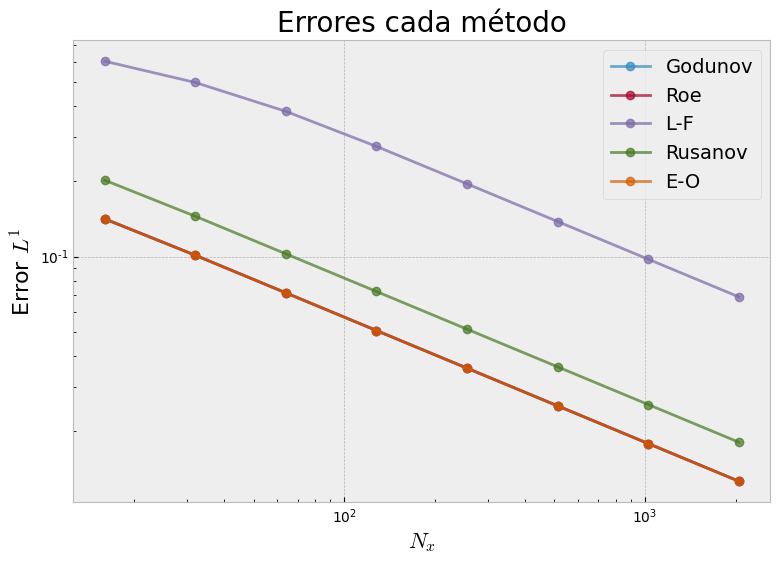

In [400]:
plt.plot(Ns, errores_god, "o-", label="Godunov", alpha=.7)
plt.plot(Ns, errores_lin, "o-", label="Roe", alpha=.7)
plt.plot(Ns, errores_lf, "o-", label="L-F", alpha=.7)
plt.plot(Ns, errores_rus, "o-", label="Rusanov", alpha=.7)
plt.plot(Ns, errores_eo, "o-", label="E-O", alpha=.7)

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.xlabel(r"$N_x$")
plt.ylabel(r"Error $L^1$")

plt.title("Errores cada método")
plt.savefig("Charts/Comparativa/errores_1.png")
plt.show()

### Segunda condición inicial

In [411]:
godunovs_2 = []
lineals_2 = []
LFs_2 = []
rusanovs_2 = []
EOs_2 = []

T = .5
Nts = [int(T//((xR - xL) / (2*N))) for N in Ns]

for i in range(len(Ns)):
    N = Ns[i]
    Nt = Nts[i]
    
    god_2 = Simplified_Godunov_solver(N, xL, xR, Nt, tf, f, 0)
    lin_2 = Linearized_solver(N, xL, xR, Nt, tf, f)
    LF_2 = L_F_solver(N, xL, xR, Nt, tf, f)
    rus_2 = Rusanov_solver(N, xL, xR, Nt, tf, f)
    EO_2 = Simplified_E_O_solver(N, xL, xR, Nt, tf, f, 0)

    
    god_2.set_init_cond(U_0_2)
    lin_2.set_init_cond(U_0_2)
    LF_2.set_init_cond(U_0_2)
    rus_2.set_init_cond(U_0_2)
    EO_2.set_init_cond(U_0_2)
    
    
    godunovs_2 += [god_2]
    lineals_2 += [lin_2]
    LFs_2 += [LF_2]
    rusanovs_2 += [rus_2]
    EOs_2 += [EO_2]

In [412]:
# Resuelve cada método

# Tiempo final


for i in range(len(Ns)):
    Nt = Nts[i]
    for n in range(0,Nt-1):
        godunovs_2[i].CFL_condition()
        godunovs_2[i].update()
        
        lineals_2[i].CFL_condition()
        lineals_2[i].update()
        
        LFs_2[i].CFL_condition()
        LFs_2[i].update()
        
        rusanovs_2[i].CFL_condition()
        rusanovs_2[i].update()
        
        EOs_2[i].CFL_condition()
        EOs_2[i].update()
        
        t += dt

In [415]:
errores_god_2 = []
errores_lin_2 = []
errores_lf_2 = []
errores_rus_2 = []
errores_eo_2 = []

for n in range(len(Ns)):
    norm_teo = np.linalg.norm(u_2(godunovs_2[n].x, T))
    norm_dif = np.linalg.norm(np.fabs(godunovs_2[n].U[-1]-u_2(godunovs_2[n].x, T)), 1)

    error_god_2 = norm_dif/norm_teo
    errores_god_2 += [error_god_2]
    
    
    
    norm_teo = np.linalg.norm(u_2(lineals_2[n].x, T))
    norm_dif = np.linalg.norm(np.fabs(lineals_2[n].U[-1]-u_2(lineals_2[n].x, T)), 1)

    error_lin_2 = norm_dif/norm_teo
    errores_lin_2 += [error_lin_2]
    
    
    
    norm_teo = np.linalg.norm(u_2(LFs_2[n].x, T))
    norm_dif = np.linalg.norm(np.fabs(LFs_2[n].U[-1]-u_2(LFs_2[n].x, T)), 1)

    error_lf_2 = norm_dif/norm_teo
    errores_lf_2 += [error_lf_2]
    
    
    
    norm_teo = np.linalg.norm(u_2(rusanovs_2[n].x, T))
    norm_dif = np.linalg.norm(np.fabs(rusanovs_2[n].U[-1]-u_2(rusanovs_2[n].x, T)), 1)

    error_rus_2 = norm_dif/norm_teo
    errores_rus_2 += [error_rus_2]
    
    
    norm_teo = np.linalg.norm(u_2(EOs_2[n].x, T))
    norm_dif = np.linalg.norm(np.fabs(EOs_2[n].U[-1]-u_2(EOs_2[n].x, T)), 1)

    error_eo_2 = norm_dif/norm_teo
    errores_eo_2 += [error_eo_2]

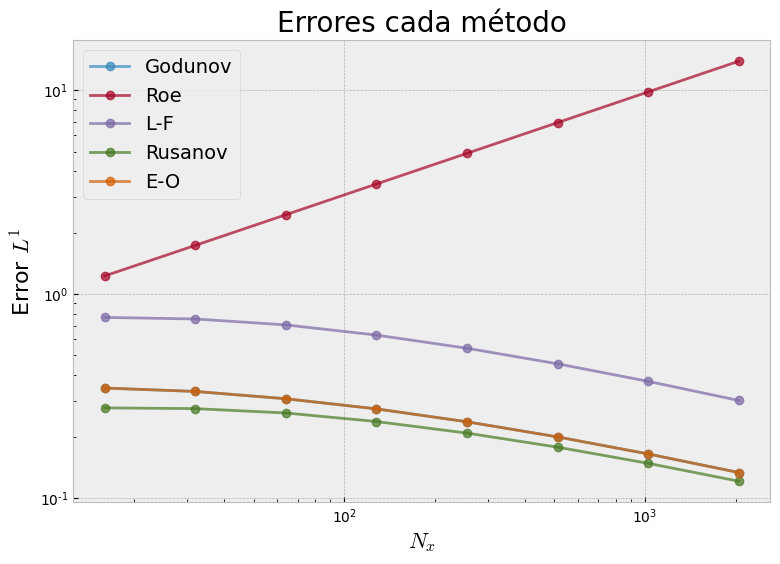

In [416]:
plt.plot(Ns, errores_god_2, "o-", label="Godunov", alpha=.7)
plt.plot(Ns, errores_lin_2, "o-", label="Roe", alpha=.7)
plt.plot(Ns, errores_lf_2, "o-", label="L-F", alpha=.7)
plt.plot(Ns, errores_rus_2, "o-", label="Rusanov", alpha=.7)
plt.plot(Ns, errores_eo_2, "o-", label="E-O", alpha=.7)

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.xlabel(r"$N_x$")
plt.ylabel(r"Error $L^1$")

plt.title("Errores cada método")
plt.savefig("Charts/Comparativa/errores_2.png")
plt.show()

## Esquemas de segundo orden (mayor resolución)

In [160]:
# Parametros grillas
Nxs = [40, 80, 160, 320]
xL = 0
xR = 1
Nt = 2_000
tf = 2
a = 1

# Flujo
def f_adv(u):
    return a*u

# Flujo para godunov
def flux_adv(u_left, u_right):
    return f_adv(u_left)

# Condicion inicial
def U_0(x):
    return np.sin(4 * np.pi * x)

# Solución real
def u_adv(x, t):
    return np.sin(4 * np.pi * (x - t))

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


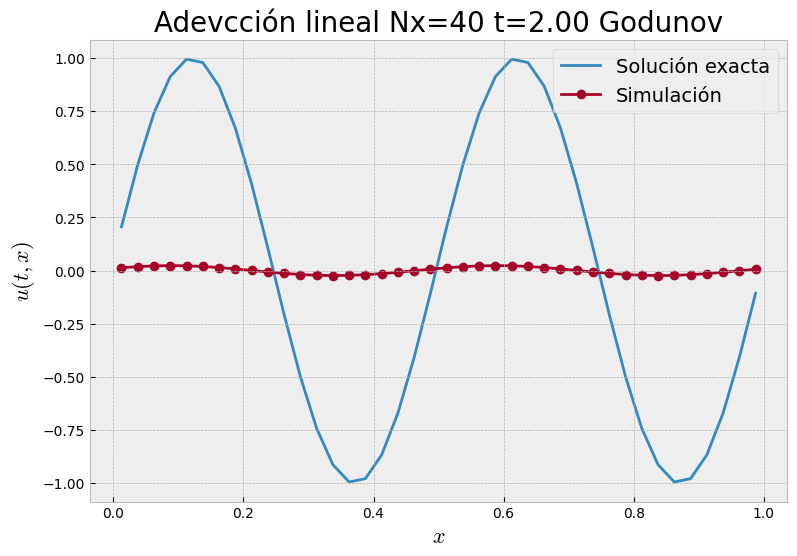

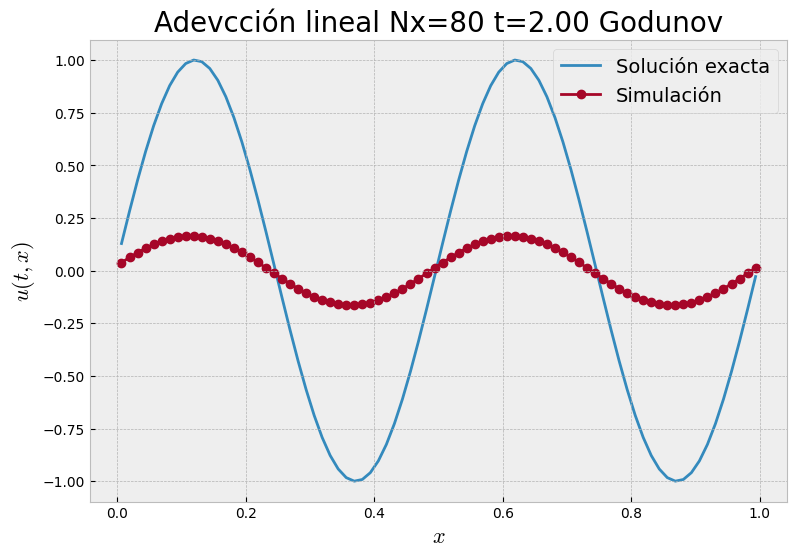

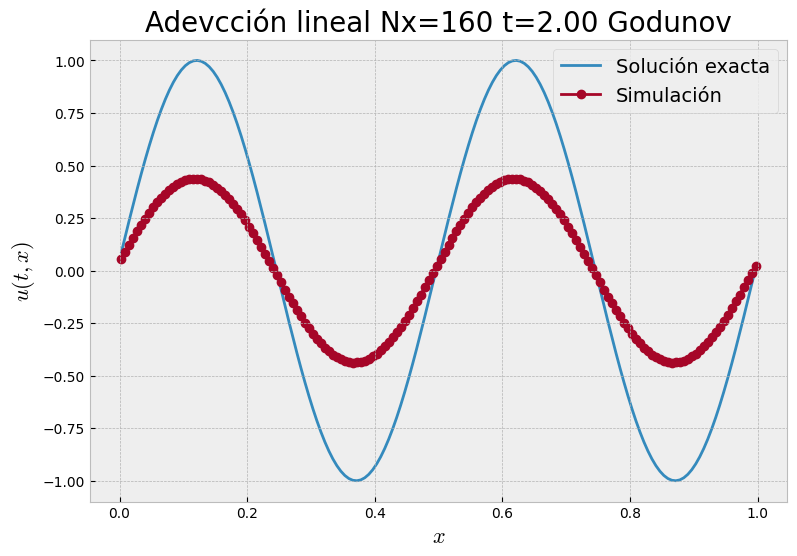

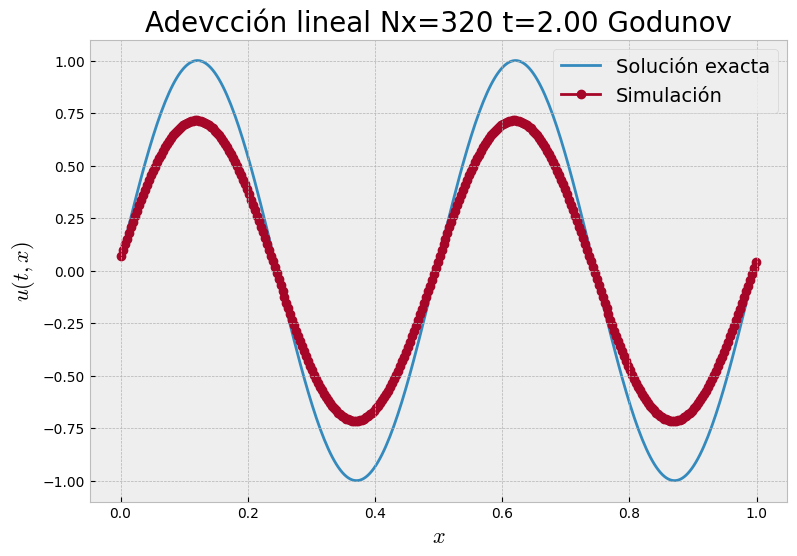

In [161]:
# Solución ecuacion de adveccion para distintos refinamientos

for i in range(len(Nxs)):
    advection = Godunov_periodic_solver(Nxs[i], xL, xR, Nt, tf, f_adv, flux_adv)
    advection.set_init_cond(U_0)

    for n in range(0,Nt-1):
        advection.CFL_condition()
        advection.update()

    advection.get_animation_exact("Adevcción lineal Nx={}".format(Nxs[i]), 
                            "Charts/Second_order/Godunov/adv_Nx_{}.gif".format(Nxs[i]), 
                            u_adv)

### Lax-Wendroff

In [ ]:
class L_W_Solver(Finite_Volume):
    def __init__(self, Nx, xL, xR, Nt, tf, f):
        super().__init__(Nx, xL, xR, Nt, tf, f)

        self.get_f_prime()

        # Esquema
        self.scheme = "Lax-Wendroff"
    
    def scheme_flux(self, u_left, u_right):
        a = self.f_prime((u_left + u_right)/2)

        output_1 = (self.f(u_left) + self.f(u_right))/2 
        output_2 = ((a * self.dt)/ (2 * self.dx)) * (self.f(u_right) - self.f(u_left))

        return output_1 - output_2

In [ ]:
# Parametros grillas
Nx = 100
xL = 0
xR = 1
Nt = 1000
tf = 1
a = 1

In [ ]:
L_W = L_W_Solver(Nx, xL, xR, Nt, tf, f_adv)
L_W.set_init_cond(U_0)
for n in range(0,Nt-1):
    L_W.CFL_condition()
    L_W.update()

L_W.get_animation_exact("L_W", "Charts/Second_order/L_W/adveccion.gif", u_adv) 